In [27]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, concatenate
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import matplotlib.pyplot as plt
import cv2  # or use PIL for image handling
import joblib

In [28]:
working_OS = 'Windows'

if working_OS == 'MacOS':
    os.chdir(r"/Users/jordanlee/Code/School/CSCI416/music-genre-classification")
    print("Current Working Directory:", os.getcwd())

elif working_OS == 'Windows':
    os.chdir(r"C:\Code\School\CSCI416\music_genre_classification\music-genre-classification")
    print("Current Working Directory:", os.getcwd())

Current Working Directory: C:\Code\School\CSCI416\music_genre_classification\music-genre-classification


In [29]:
df = pd.read_csv('data/features/aug_features_cleaned.csv')
X = df.drop(columns=['label'])
y = df['label']
label_encoder =LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_tabular, X_test_tabular, y_train_tabular, y_test_tabular = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [30]:
X_train_tabular.shape[1]

58

In [31]:
def generate_spectrogram(audio_path, output_path, sr=22050):
    """
    Generate a spectrogram from an audio file and save it as a PNG.
    
    Parameters:
    - audio_path: Path to the audio file.
    - output_path: Path to save the generated spectrogram.
    - sr: Sampling rate for loading the audio.
    """
    # Load audio file
    y, sr = librosa.load(audio_path, sr=sr)
    
    # Create a mel-spectrogram
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    # Plot and save the spectrogram
    plt.figure(figsize=(4, 4))
    librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000, cmap='viridis')
    plt.axis('off')  # Remove axes for a cleaner PNG
    plt.tight_layout(pad=0)
    plt.savefig(output_path, dpi=100, bbox_inches='tight', pad_inches=0)
    plt.close()


KeyboardInterrupt: 

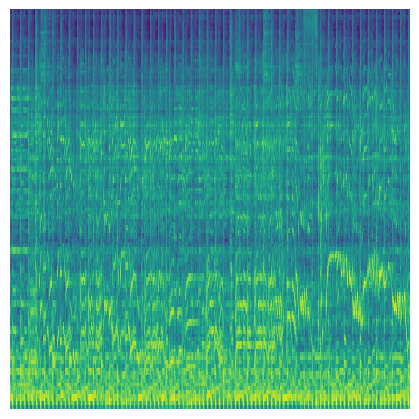

In [8]:
augmented_audio_dir = "data/augmented"
spectrogram_dir = "data/aug_spectrograms"

# Create spectrogram directory if it doesn't exist
os.makedirs(spectrogram_dir, exist_ok=True)

# Loop through all audio files in the augmented directory
for root, dirs, files in os.walk(augmented_audio_dir):
    for file in files:
        if file.endswith(".wav"):  # Ensure only audio files are processed
            genre = os.path.basename(root)  # Use folder name as genre
            genre_dir = os.path.join(spectrogram_dir, genre)
            os.makedirs(genre_dir, exist_ok=True)  # Create genre folder if needed
            
            # File paths
            audio_path = os.path.join(root, file)
            spectrogram_path = os.path.join(genre_dir, file.replace(".wav", ".png"))
            
            # Generate spectrogram
            generate_spectrogram(audio_path, spectrogram_path)

In [32]:
spectrogram_dir = 'data/aug_spectrograms'  # Path to the spectrograms folder

In [33]:
def load_spectrograms_and_labels(spectrogram_dir):
    spectrograms = []  # List to store spectrogram data
    labels = []        # List to store genre labels
    
    # Loop through all subdirectories (each representing a genre)
    for genre in os.listdir(spectrogram_dir):
        genre_folder = os.path.join(spectrogram_dir, genre)
        
        # Skip files, process only directories
        if os.path.isdir(genre_folder):
            for img_file in os.listdir(genre_folder):
                img_path = os.path.join(genre_folder, img_file)
                
                # Read the image using PIL (you can resize or preprocess here if needed)
                img = Image.open(img_path).convert('L')  # Convert to grayscale ('L')
                img = img.resize((128, 128))  # Resize to 128x128 (adjust as needed)
                
                # Convert image to numpy array
                img_array = np.array(img)
                
                # Append the image and its genre label
                spectrograms.append(img_array)
                labels.append(genre)  # The genre is the label for classification
    
    # Convert lists to numpy arrays
    X_spectrograms = np.array(spectrograms)
    y_labels = np.array(labels)
    
    return X_spectrograms, y_labels

In [34]:
# Load spectrograms and labels
X_spectrograms, y_labels = load_spectrograms_and_labels(spectrogram_dir)

# Normalize pixel values (between 0 and 1)
X_spectrograms = X_spectrograms.astype('float32') / 255.0

# Reshape to add channel dimension (since images are grayscale, the channel is 1)
X_spectrograms = X_spectrograms.reshape(-1, 128, 128, 1)

# Encode labels (genres) as numeric values
label_encoder = LabelEncoder()
y_labels_encoded = label_encoder.fit_transform(y_labels)

# Optional: one-hot encode the labels if needed (for multi-class classification)
y_labels_one_hot = np.eye(len(label_encoder.classes_))[y_labels_encoded]

In [35]:
# Split the data into training and test sets (80% train, 20% test)
X_train_spectrogram, X_test_spectrogram, y_train, y_test = train_test_split(
    X_spectrograms, y_labels_one_hot, test_size=0.2, random_state=42
)

In [44]:
# Define the input for tabular data
tabular_input = layers.Input(shape=(X_train_tabular.shape[1],))  # Adjust shape based on your tabular data

# Define the input for spectrogram images
spectrogram_input = layers.Input(shape=(128, 128, 1))  # Adjust shape based on your spectrogram size

# Tabular data processing: Dense layers
tabular_x = layers.Dense(64, activation='relu')(tabular_input)
tabular_x = layers.Dense(32, activation='relu')(tabular_x)

# Spectrogram data processing: Convolutional layers
spectrogram_x = layers.Conv2D(32, (3, 3), activation='relu')(spectrogram_input)
spectrogram_x = layers.MaxPooling2D((2, 2))(spectrogram_x)
spectrogram_x = layers.Conv2D(64, (3, 3), activation='relu')(spectrogram_x)
spectrogram_x = layers.MaxPooling2D((2, 2))(spectrogram_x)
spectrogram_x = layers.Flatten()(spectrogram_x)

# Concatenate the two branches (tabular and spectrogram)
combined = layers.concatenate([tabular_x, spectrogram_x])

# Dense layers after concatenation
x = layers.Dense(128, activation='relu')(combined)
x = layers.Dense(64, activation='relu')(x)

# Output layer (for classification)
output = layers.Dense(y_train.shape[1], activation='softmax')(x)  # Softmax for multi-class classification

# Define the model
small_aug_model = models.Model(inputs=[tabular_input, spectrogram_input], outputs=output)

# Compile the model
small_aug_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to visualize the architecture
small_aug_model.summary()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 126, 126,  │        320 │ input_layer_11[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 63, 63,    │          0 │ conv2d_13[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_10      │ (None, 58)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 61, 61,    │     18,496 │ max_pooling2d_10… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 64)        │      3,776 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 30, 30,    │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 32)        │      2,080 │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 57600)     │          0 │ max_pooling2d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_5       │ (None, 57632)     │          0 │ dense_26[0][0],   │
│ (Concatenate)       │                   │            │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_27 (Dense)    │ (None, 128)       │  7,377,024 │ concatenate_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_28 (Dense)    │ (None, 64)        │      8,256 │ dense_27[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 10)        │        650 │ dense_28[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,410,602 (28.27 MB)

 Trainable params: 7,410,602 (28.27 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
# Tabular input branch
tabular_input = layers.Input(shape=(X_train_tabular.shape[1],))
tabular_x = layers.BatchNormalization()(tabular_input)
tabular_x = layers.Dense(128, activation='relu')(tabular_x)
tabular_x = layers.Dropout(0.3)(tabular_x)
tabular_x = layers.Dense(64, activation='relu')(tabular_x)
tabular_x = layers.Dropout(0.2)(tabular_x)

# Spectrogram input branch
spectrogram_input = layers.Input(shape=(128, 128, 1))
spec_x = layers.BatchNormalization()(spectrogram_input)
spec_x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(spec_x)
spec_x = layers.BatchNormalization()(spec_x)
spec_x = layers.MaxPooling2D((2, 2))(spec_x)
spec_x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(spec_x)
spec_x = layers.BatchNormalization()(spec_x)
spec_x = layers.MaxPooling2D((2, 2))(spec_x)
spec_x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(spec_x)
spec_x = layers.BatchNormalization()(spec_x)
spec_x = layers.Flatten()(spec_x)

# Concatenate branches
combined = layers.concatenate([tabular_x, spec_x])

# More robust classification layers
x = layers.Dense(256, activation='relu')(combined)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

# Output layer
output = layers.Dense(y_train.shape[1], activation='softmax')(x)

# Create model
large_aug_model = models.Model(inputs=[tabular_input, spectrogram_input], outputs=output)

# Compile the model
large_aug_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to visualize the architecture
large_aug_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │          4 │ input_layer_13[0… │
│ (BatchNormalizatio… │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 128, 128,  │        320 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_12      │ (None, 58)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 58)        │        232 │ input_layer_12[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_16[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 128)       │      7,552 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 128)       │          0 │ dense_30[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_13… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 64)        │      8,256 │ dropout_12[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_17[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 64)        │          0 │ dense_31[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 131072)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_6       │ (None, 131136)    │          0 │ dropout_13[0][0]

 Total params: 33,716,406 (128.62 MB)

 Trainable params: 33,715,072 (128.61 MB)

 Non-trainable params: 1,334 (5.21 KB)

In [64]:
joblib.dump(small_aug_model, 'models/small_aug_CNN_model.joblib')
joblib.dump(large_aug_model, 'models/large_aug_CNN_model.joblib')

['models/large_aug_CNN_model.joblib']

In [47]:
# Initialize the ImageDataGenerator for augmentation
datagen = ImageDataGenerator(
    rotation_range=30,       # Random rotations
    width_shift_range=0.2,   # Random width shifts
    height_shift_range=0.2,  # Random height shifts
    shear_range=0.2,         # Random shearing
    zoom_range=0.2,          # Random zoom
    horizontal_flip=True,    # Random horizontal flip
    fill_mode='nearest'      # Fill missing pixels after transformations
)

# Fit the generator on your training data
datagen.fit(X_train_spectrogram)

In [48]:
small_aug_model.fit(
    [X_train_tabular, X_train_spectrogram], y_train,
    epochs=10, 
    batch_size=32, 
    validation_data=([X_test_tabular, X_test_spectrogram], y_test),
    steps_per_epoch=len(X_train_spectrogram)
)

Epoch 1/10
  75/2397 ━━━━━━━━━━━━━━━━━━━━ 3:14 84ms/step - accuracy: 0.1736 - loss: 2.2508

c:\Users\jplee\anaconda3\envs\genre_classification\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2397/2397 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.2402 - loss: 2.0723 - val_accuracy: 0.3383 - val_loss: 1.7907
Epoch 2/10
2397/2397 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.4492 - loss: 1.4652 - val_accuracy: 0.4767 - val_loss: 1.3728
Epoch 3/10
2397/2397 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.5679 - loss: 1.2020 - val_accuracy: 0.5483 - val_loss: 1.2072
Epoch 4/10
2397/2397 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6255 - loss: 1.0393 - val_accuracy: 0.5883 - val_loss: 1.1225
Epoch 5/10
2397/2397 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6807 - loss: 0.8646 - val_accuracy: 0.6500 - val_loss: 0.9747
Epoch 6/10
2397/2397 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7284 - loss: 0.7545 - val_accuracy: 0.6400 - val_loss: 0.9756
Epoch 7/10
2397/2397 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7857 - loss: 0.6085 - val_accuracy: 0.7367 - val_loss: 0.7939
Epoch 8/10
2397/2397 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8469 - loss: 0.4702 - val_accurac

In [51]:
large_aug_model.fit(
    [X_train_tabular, X_train_spectrogram], y_train, 
    epochs=10, 
    batch_size=32, 
    validation_data=([X_test_tabular, X_test_spectrogram], y_test),
    steps_per_epoch=len(X_train_spectrogram)
)

Epoch 1/10
  75/2397 ━━━━━━━━━━━━━━━━━━━━ 13:22 346ms/step - accuracy: 0.9920 - loss: 0.0558

c:\Users\jplee\anaconda3\envs\genre_classification\lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2397/2397 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.9917 - loss: 0.0542 - val_accuracy: 0.6050 - val_loss: 1.4902
Epoch 2/10
2397/2397 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.9933 - loss: 0.0406 - val_accuracy: 0.7567 - val_loss: 0.8073
Epoch 3/10
2397/2397 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.9934 - loss: 0.0354 - val_accuracy: 0.7133 - val_loss: 0.9450
Epoch 4/10
2397/2397 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.9921 - loss: 0.0350 - val_accuracy: 0.8083 - val_loss: 0.6306
Epoch 5/10
2397/2397 ━━━━━━━━━━━━━━━━━━━━ 49s 20ms/step - accuracy: 0.9975 - loss: 0.0235 - val_accuracy: 0.8283 - val_loss: 0.6092
Epoch 6/10
2397/2397 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.9974 - loss: 0.0162 - val_accuracy: 0.8150 - val_loss: 0.6277
Epoch 7/10
2397/2397 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.9987 - loss: 0.0140 - val_accuracy: 0.8483 - val_loss: 0.4929
Epoch 8/10
2397/2397 ━━━━━━━━━━━━━━━━━━━━ 27s 11ms/step - accuracy: 0.9712 - loss: 0.09

In [56]:
test_small_loss, test_small_accuracy = small_aug_model.evaluate([X_test_tabular, X_test_spectrogram], y_test)

# Print the results
print(f"Test loss: {test_small_loss}")
print(f"Test accuracy: {test_small_accuracy}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7739 - loss: 0.7967
Test loss: 0.7505571842193604
Test accuracy: 0.7699999809265137


In [57]:
test_large_loss, test_large_accuracy = large_aug_model.evaluate([X_test_tabular, X_test_spectrogram], y_test)

# Print the results
print(f"Test loss: {test_large_loss}")
print(f"Test accuracy: {test_large_accuracy}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.6040 - loss: 1.4010
Test loss: 1.3231276273727417
Test accuracy: 0.6233333349227905


In [61]:
# Make predictions on the test data
y_pred = small_aug_model.predict([X_test_tabular, X_test_spectrogram])

# Convert predictions to class labels (if using softmax, for classification)
y_pred_classes = y_pred.argmax(axis=1)

# Print predictions for the first few test samples
print(f"Predicted classes: {y_pred_classes[:5]}")
print(f"True classes: {y_test[:5]}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Predicted classes: [4 3 0 9 0]
True classes: [[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [62]:
# Convert y_test (one-hot encoded) to integer labels
y_test_classes = np.argmax(y_test, axis=1)

# Now compare the predicted classes with the true class labels
print(f"Predicted classes: {y_pred_classes[:5]}")
print(f"True classes: {y_test_classes[:5]}")

Predicted classes: [4 3 0 9 0]
True classes: [4 3 0 9 0]


In [63]:
# Confusion Matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Classification Report (precision, recall, f1-score)
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes))

Confusion Matrix:
[[58  0  1  3  0  3  1  0  2  5]
 [ 0 65  0  0  0  4  0  0  0  0]
 [ 6  0 43  1  0  2  0  0  1  5]
 [ 0  0  3 48  2  0  0  1  0  5]
 [ 1  0  0  6 40  0  2  0  2  2]
 [ 5  4  0  2  0 38  0  0  0  2]
 [ 0  0  0  0  1  0 54  0  0  1]
 [ 1  1  3 10  0  0  1 36  0  5]
 [ 4  0  1  8  3  0  0  1 40  1]
 [ 6  0  3 11  0  1  1  2  2 40]]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.79      0.75        73
           1       0.93      0.94      0.94        69
           2       0.80      0.74      0.77        58
           3       0.54      0.81      0.65        59
           4       0.87      0.75      0.81        53
           5       0.79      0.75      0.77        51
           6       0.92      0.96      0.94        56
           7       0.90      0.63      0.74        57
           8       0.85      0.69      0.76        58
           9       0.61      0.61      0.61        66

    accuracy                    